# Loading and plotting a fluorescence spectrum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from agepy.spec.photons import Spectrum, DldAnodeUVW
from agepy import ageplot
ageplot.use("age")

Create an anode instance corresponding to the detector type and pass the rotation.

In [2]:
anode = DldAnodeUVW(-97.8)

Load the data from the h5 file. Pass the correct h5 paths to the raw
data and if applicable the paths to recorded normalization data
(e.g. target density or upstream intensity or ...). 

In [3]:
spectrum = Spectrum.from_h5(
    "spectrum.h5",  # Path to the h5 file
    anode,  # Anode object
    raw = "dld_rd#raw",  # Path to the raw data in the h5 file
    time = 600,  # Optional, acquisition time in seconds
    target_density = "baratron#value",  # Optional, path to the target density in the h5 file
    upstream_intensity = "mirror#value",  # Optional, path to the upstream intensity in the h5 file
)

Optionally, convert the units of the normalization data:

In [4]:
print("Target density:")
print("{0:.2e} +- {1:.2e}".format(*spectrum.target_density), "torr", end=" ")
spectrum.convert_unit("target_density", "torr", "mbar")
print("->", "{0:.2e} +- {1:.2e}".format(*spectrum.target_density), "mbar")

Target density:
3.46e-02 +- 1.34e-03 torr -> 4.61e-02 +- 1.79e-03 mbar


In [5]:
print("Upstream intensity:")
print("{0:.2e} +- {1:.2e}".format(*spectrum.upstream_intensity), "A", end=" ")
spectrum.convert_unit("upstream_intensity", "A", "nA")
print("->", "{0:.2e} +- {1:.2e}".format(*spectrum.upstream_intensity), "nA")

Upstream intensity:
1.10e-10 +- 3.17e-13 A -> 1.10e-01 +- 3.17e-04 nA


Visualize the detector image:

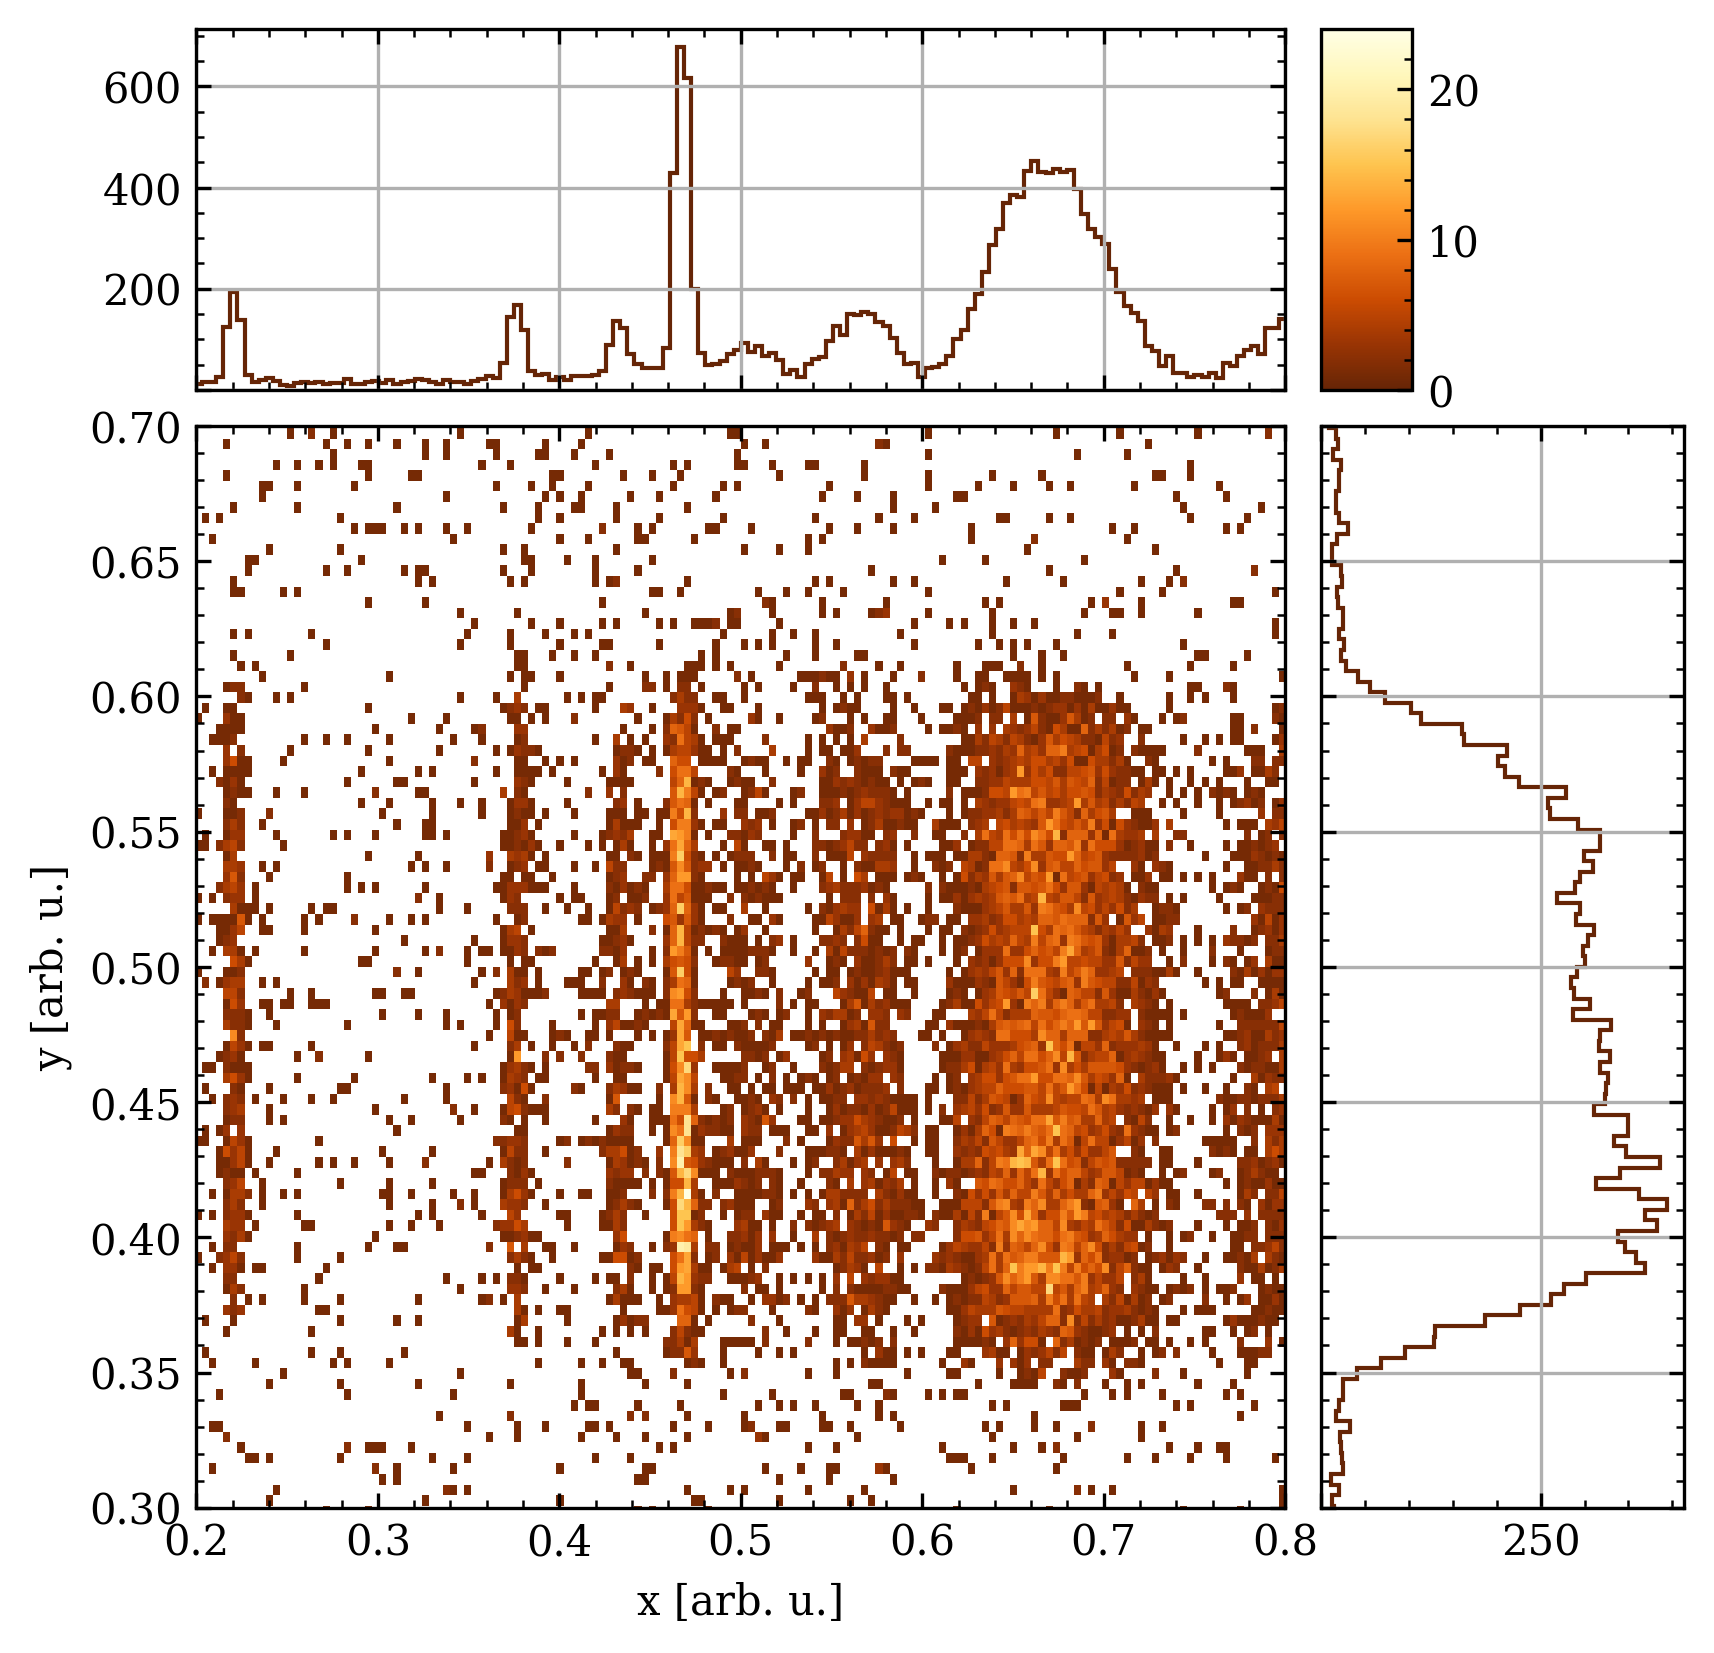

In [6]:
bins = np.histogram([], bins=256, range=(0, 1))[1]
fig, ax = spectrum.det_image(bins=bins, x_lim=(0.2, 0.8), y_lim=(0.3, 0.7))
plt.show()

Define a region of interest on the detector surface:

In [7]:
# Define a ROI
roi = ((0.16, 0.80), (0.42, 0.52))

Create some dummy detector efficiencies with uncertainties that need to
be propagated:

In [8]:
# Simulate detector efficiencies
qeff_x = np.linspace(0.1, 0.9, 30)
qeff_val = np.ones(30) * 0.9
qeff_err = np.ones(30) * 0.15

Create a dummy wavelength calibration with uncertainties that need to be
propagated:

In [9]:
# Define wavelength calibration
a0 = (128.67, 0.07)
a1 = (38.94, 0.01)
calib = (a0, a1)

Histogram the data while propagating the uncertainties from the calibration
and quantum efficiencies using Monte Carlo error propagation:

In [10]:
spec, err, edges = spectrum.spectrum(
    256,
    roi=roi,
    qeff=(qeff_val, qeff_err, qeff_x),
    calib=calib,
    mc_errors=True,
    mc_samples=10000,
    mc_seed=42,
    mc_spectrum=False,
)

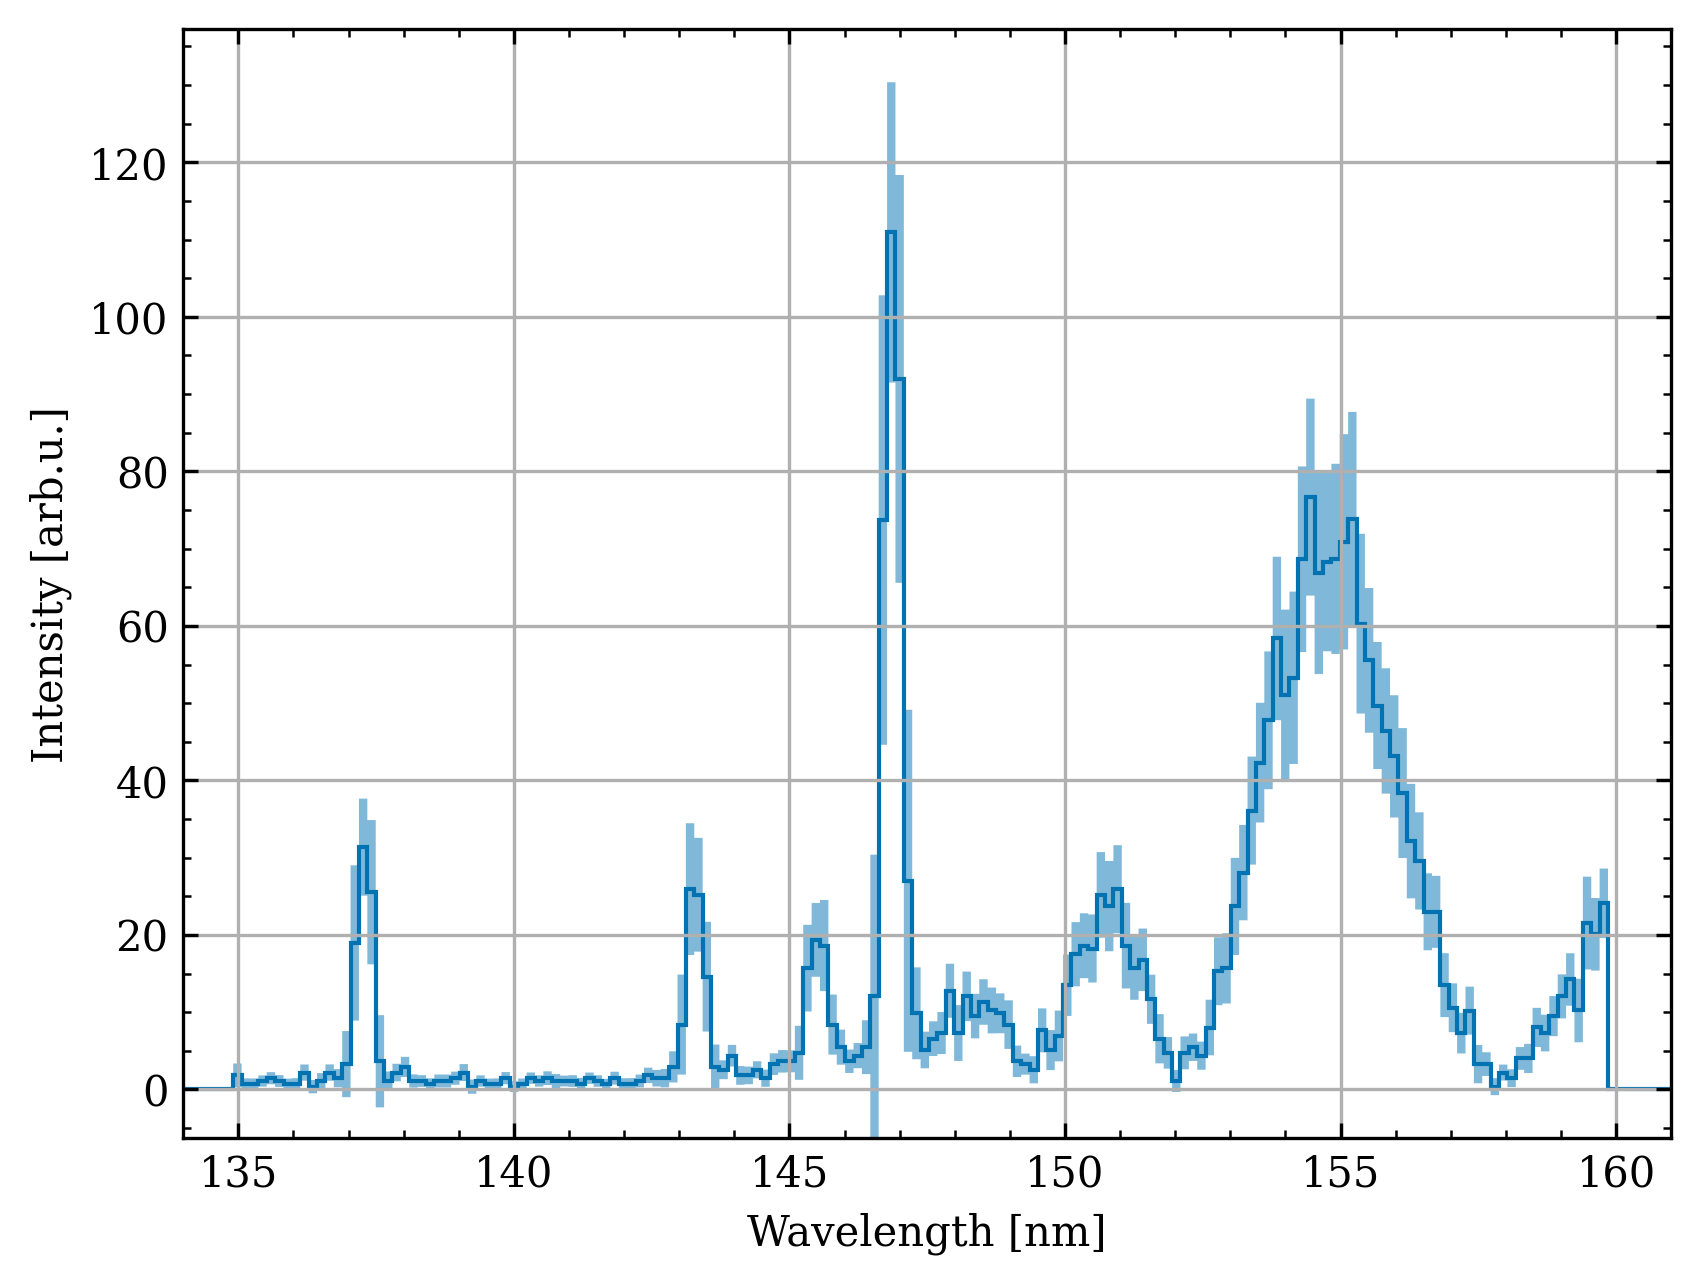

In [11]:
fig, ax = plt.subplots()
ax.stairs(spec, edges, color=ageplot.colors[0])
ax.stairs(spec + err, edges, baseline=spec - err, color=ageplot.colors[0], fill=True, alpha=0.5)
ax.set_xlim(134, 161)
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Intensity [arb.u.]")
plt.show()